In [1]:
import pandas as pd

data = pd.read_csv("TypoDomains.csv")

In [2]:
data = data[['domain','score']]

In [3]:
data.insert(2, 'label', -1)

In [4]:
def labeling(score):
    if score > 54:
        return 1
    else:
        return 0

data['label'] = data['score'].apply(lambda i : labeling(i))

In [5]:
data.head()

,domain,score,label
0,google0.com,95,1
1,google1.com,95,1
2,google2.com,92,1
3,google3.com,95,1
4,google4.com,95,1


In [6]:
data.label.value_counts()  # phishing : 64% / benign : 36%

1    1555
0     888
Name: label, dtype: int64

In [7]:
data.insert(3, "targetBrand", "")
# 0 ~ 249 google
# 250 ~ 518 facebook
# 519 ~ 834 microsoft
# 835 ~ 1043 apple
# 1044 ~ 1323 wellsfargo
# 1324 ~ 1605 amazon
# 1606 ~ 1799 walmart
# 1800 ~ 1987 roblox
# 1988 ~ 2214 linkedin
# 2215 ~ 2442 homedepot

In [8]:
for i in range(len(data)):
    if i >= 0 and i <= 249:
        data.at[i, "targetBrand"] = "google.com"
    elif i > 249 and i < 519:
        data.at[i, "targetBrand"] = "facebook.com"
    elif i > 518 and i < 835:
        data.at[i, "targetBrand"] = "microsoft.com"
    elif i > 834 and i < 1044:
        data.at[i, "targetBrand"] = "apple.com"
    elif i > 1043 and i < 1324:
        data.at[i, "targetBrand"] = "wellsfargo.com"
    elif i > 1323 and i < 1606:
        data.at[i, "targetBrand"] = "amazon.com"
    elif i > 1605 and i < 1800:
        data.at[i, "targetBrand"] = "walmart.com"
    elif i > 1799 and i < 1988:
        data.at[i, "targetBrand"] = "roblox.com"
    elif i > 1987 and i < 2215:
        data.at[i, "targetBrand"] = "linkedin.com"
    elif i > 2214 and i < 2443:
        data.at[i, "targetBrand"] = "homedepot.com"


In [10]:
data.head()

,domain,score,label,targetBrand
0,google0.com,95,1,google.com
1,google1.com,95,1,google.com
2,google2.com,92,1,google.com
3,google3.com,95,1,google.com
4,google4.com,95,1,google.com


In [141]:
import re

def strToToken(tld):
    if type(tld) == int:
        return 0
    
    token = ''
    for ch in tld:
        token += str(ord(ch))
        
    return token



def length(domain):
    return len(domain)

def digit(domain):
    count = 0
    for i in domain:
        if i.isdigit():
            count = count + 1
    return count

def hyphen(domain):
    hyp = len(re.findall("-", domain))
    return hyp

def dotCount(domain): 
    dot = len(re.findall(r"\.", domain))
    return dot

def subDomain(domain): # fld => 기본적으로 dot 1개, sub domain이 붙으면 dot + 1
    sub = len(re.findall(r"\.", domain)) - 1 
    return sub

def diffLength(domain):
    original = len(data[data['domain'] == domain].targetBrand.values[0])
    return len(domain) - original

def checkDigit(domain):
    for ch in domain:
        if ch.isdigit():
            return 1 # 하나라도 숫자가 있으면 1 반환 

    return 0 #없으면 0

def checkAddAlpha(domain):
    original = data[data['domain'] == domain].targetBrand.values[0]
    
    if len(domain) > len(original):
        for ch in domain:
            if ch.isdigit():
                return 0 # 숫자가 포함되면 알파벳 addition 경우가 아님 
        return 1
    else:
        return 0 #omission의 경우는 domain 길이가 original 길이보다 짧음 
    

def ExtractWord(domain):
    # domain에서 original을 빼면 추가된 word or character가 나오겠지 
    # 그 길이가 2 이상이면 1 아니면 0
    if len(re.findall(r"\.", domain)) > 1: # sub domain이 있는 경우는 word addition X. 제외 
        return 0
    
    original = data[data['domain'] == domain].targetBrand.values[0]
    original = re.split(r"\.", original)[-2] # google.com => google
    
    domain = re.split(r"\.", domain)[-2] # google0.com => google0
    result = domain.replace(original,"") # googel0 exp(google) => 0
    
    if (result == domain) | (result == '') | (len(result) <= 1): # 문자가 추가된 경우가 아니거나 || tld swap || addition
        return 0
    
    return strToToken(result)

def checkWord(word): # ExtracWord result로 실행
    if len(str(word)) >= 2:
        return 1
    return 0

def tldLength(domain):
    domains = re.split(r"\.", domain)
    tld = domains[-1]
    return len(tld)

def ExtractTld(domain):
    domains = re.split(r"\.", domain)
    tld = domains[-1]
    return strToToken(tld)

def tailOrHead(domain):
    original = data[data['domain'] == domain].targetBrand.values[0]
    original = re.split(r"\.", original)[-2] # google.com => google
    domain = re.split(r"\.", domain)[-2] # google0.com => google0
    
    result = domain.replace(original,"") # googel0 exp(google) => 0 :: addition의 경우에만 결과가 나옴 
    
    if(len(result) == 1):
        return 1
    else:
        return 0

In [142]:
from collections import Counter

def checkCharset(domain):
    # domain 값을 문자 배열로 변환 
    # 문자 당 개수로 dictionary 생성
    # 오름차순 정렬
    # if domain != origin 인데 두 도메인을 정렬한 dictionary 값은 동일하면 1 == transposition
    # 아니면 0 반환 
    
    a1 = []
    a2 = []
    original = data[data['domain'] == domain].targetBrand.values[0]
    
    original = re.split(r"\.", original)[-2] # tld는 제외
    domain = re.split(r"\.", domain)[-2]
    
    for ch in domain:
        a2.append(ch)
        
    for ch in original:
        a1.append(ch)
    
    count_array1 = dict(sorted(Counter(a1).items()))
    count_array2 = dict(sorted(Counter(a2).items()))
    
#     count_array1 = dict(sorted(count_array1.items()))
#     count_array2 = dict(sorted(count_array2.items()))
    
    if (count_array1 == count_array2):
        return 1
    else:
        return 0


In [143]:
def checkBit(domain):
    a1 = []
    a2 = []
    original = data[data['domain'] == domain].targetBrand.values[0]
    
    original = re.split(r"\.", original)[-2] # tld 제외
    domain = re.split(r"\.", domain)[-2]
    
    
    for ch in domain:
        a2.append(ch)
        
    for ch in original:
        a1.append(ch)
        
    count_array1 = dict(sorted(Counter(a1).items()))
    count_array2 = dict(sorted(Counter(a2).items()))
    
    if ((len(domain) == len(original)) & (count_array1 != count_array2)):
        return 1
    else:
        return 0

In [175]:
from itertools import groupby

def checkRepetition(domain):
    original = data[data['domain'] == domain].targetBrand.values[0]
    original = re.split(r"\.", original)[-2] # tld 제외
    domain = re.split(r"\.", domain)[-2]
    
    original_char_set = []
    domain_char_set = []
    repetition_char = []
    
    for ch in original:
        original_char_set.append(ch)
    
    for ch in domain:
        domain_char_set.append(ch)
    
    if len(domain_char_set) <= len(original): # repetition의 경우 domain_char_set 길이가 더 긺. 
        return 0
    
    repetition_char = domain_char_set
    
    
    for index in range(len(original_char_set)):
        if original_char_set[index] in domain_char_set:
            repetition_char.remove(original_char_set[index])
    # 중복된 문자만 domain_char_set에 남은 상태여야 함
    
    repetition_char = repetition_char[0]
    
    domain_repetition_cnt = []
    original_repetition_cnt = []
    
    for ch, cntCh in groupby(domain):
        if ch == repetition_char:
            domain_repetition_cnt.append(len(list(cntCh)))
    
    for ch, cntCh in groupby(original):
        if ch == repetition_char:
            original_repetition_cnt.append(len(list(cntCh)))
        
    if (len(original_repetition_cnt) != len(domain_repetition_cnt)): # 구한 list 길이가 다르면 repetition 경우가 아님 
        return 0
    
    for i in range(len(domain_repetition_cnt)):
        if (domain_repetition_cnt[i] == (original_repetition_cnt[i] + 1)):
            return 1
        else:
            continue
    
    return 0
    

In [165]:
def checkVowelset(domain):
    original = data[data['domain'] == domain].targetBrand.values[0]
    original = re.split(r"\.", original)[-2]
    domain = re.split(r"\.", domain)[-2]
    
    a1 = ''
    a2 = ''
    original_vowel_index = []
    domain_vowel_index = []
    
    for ch in range(len(original)):
        if original[ch] in ['a','e','i','o','u']:
            a1 += original[ch]
            original_vowel_index.append(1)
        else:
            original_vowel_index.append(0)
    
    for ch in range(len(domain)):
        if domain[ch] in ['a','e','i','o','u']:
            a2 += domain[ch]
            domain_vowel_index.append(1)
        else:
            domain_vowel_index.append(0)
    
    
    if (len(original) == len(domain)) & (a1 != a2) & (len(a1) == len(a2)) & (domain_vowel_index == original_vowel_index): # vowel swap만, addition은 제외
        return 1
    else:
        return 0

In [147]:
# def expectType(row):
#     if ((row.diffLength == 1) & (row.checkDigit == 1)) | ((row.diffLength == 1) & (row.checkAddAlpha == 1)):
#         return 'addition'
#     if (row.diffLength == -1):
#         return 'omission'
#     if ((row.diffLength == 0) & (row.checkBit == 1)):
#         return 'replace'
#     if (row.ExtractTld != strtotoken('com')):
#         return 'tldswap'
#     if ((row.dot == 2) & (row.subDomain == 1)):
#         return 'Dotsquatting'
#     if ((row.checkVowelset == 1) & (row.diffLength == 0)):
#         return 'vowelswap'
#     if (row.checkPositionChange == 1) & (row.diffLength == 0):
#         return 'transposition'
#     if ((row.diffLength == 1) & (row.hyphen == 1)):
#         return 'hyphen'
#     if (row.ExtractWord != 0) & (row.diffLength >=2):
#         return 'dictionary'
    

In [148]:
data['length'] = data['domain'].apply(lambda i : length(i))

In [149]:
data['digit'] = data['domain'].apply(lambda i : digit(i))

In [150]:
data['hyphen'] = data['domain'].apply(lambda i : hyphen(i))

In [151]:
data['dot'] = data['domain'].apply(lambda i : dotCount(i))

In [152]:
data['subDomain'] = data['domain'].apply(lambda i : subDomain(i))

In [153]:
data['diffLength'] = data['domain'].apply(lambda i : diffLength(i))

In [154]:
data['checkDigit'] = data['domain'].apply(lambda i : checkDigit(i))

In [155]:
data['checkAddAlpha'] = data['domain'].apply(lambda i : checkAddAlpha(i))

In [176]:
data['checkVowelset'] = data['domain'].apply(lambda i : checkVowelset(i))

In [157]:
data['ExtractWord'] = data['domain'].apply(lambda i : ExtractWord(i))

In [158]:
data['checkWord'] = data['ExtractWord'].apply(lambda i : checkWord(i))

In [159]:
data['tldLength'] = data['domain'].apply(lambda i : tldLength(i))

In [160]:
data['ExtractTld'] = data['domain'].apply(lambda i : ExtractTld(i))

In [161]:
data['tailOrHead'] = data['domain'].apply(lambda i : tailOrHead(i))

In [162]:
data['checkCharset'] = data['domain'].apply(lambda i : checkCharset(i))

In [163]:
data['checkBit'] = data['domain'].apply(lambda i : checkBit(i))

In [177]:
data['checkRepetition'] = data['domain'].apply(lambda i : checkRepetition(i))

In [172]:
data.head()

,domain,score,label,targetBrand,length,digit,hyphen,dot,subDomain,diffLength,...,checkAddAlpha,checkVowelset,ExtractWord,checkWord,tldLength,ExtractTld,tailOrHead,checkCharset,checkBit,checkRepetition
0,google0.com,95,1,google.com,11,1,0,1,0,1,...,0,0,0,0,3,99111109,1,0,0,0.0
1,google1.com,95,1,google.com,11,1,0,1,0,1,...,0,0,0,0,3,99111109,1,0,0,0.0
2,google2.com,92,1,google.com,11,1,0,1,0,1,...,0,0,0,0,3,99111109,1,0,0,0.0
3,google3.com,95,1,google.com,11,1,0,1,0,1,...,0,0,0,0,3,99111109,1,0,0,0.0
4,google4.com,95,1,google.com,11,1,0,1,0,1,...,0,0,0,0,3,99111109,1,0,0,0.0


In [178]:
data.to_csv('squattingDomains.csv',index = False)

In [65]:
googleData = data[data['targetBrand']=='google.com']
facebookData = data[data['targetBrand']=='facebook.com']
microsoftData = data[data['targetBrand']=='microsoft.com']
appleData = data[data['targetBrand']=='apple.com']
wellsfargoData = data[data['targetBrand']=='wellsfargo.com']
robloxData = data[data['targetBrand']=='roblox.com']
homedepotData = data[data['targetBrand']=='homedepot.com']
amazonData = data[data['targetBrand']=='amazon.com']
linkedinData = data[data['targetBrand']=='linkedin.com']
walmartData = data[data['targetBrand']=='walmart.com']

#############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Test Accuracy :  64.83%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.48      0.46      0.47       166
           1       0.73      0.74      0.74       323

    accuracy                           0.65       489
   macro avg       0.61      0.60      0.60       489
weighted avg       0.65      0.65      0.65       489

             Confusion_matrix 


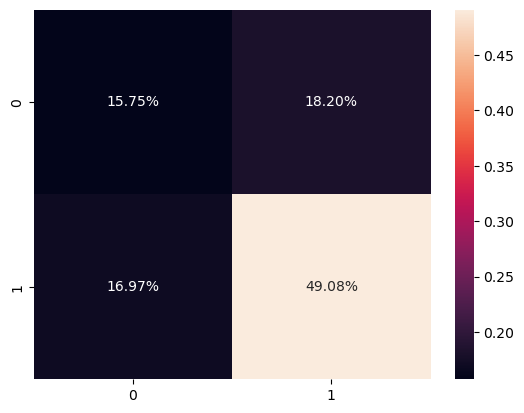

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  68.71%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.55      0.45      0.50       166
           1       0.74      0.81      0.77       323

    accuracy                           0.69       489
   macro avg       0.64      0.63      0.63       489
weighted avg       0.68      0.69      0.68       489

             Confusion_matrix 


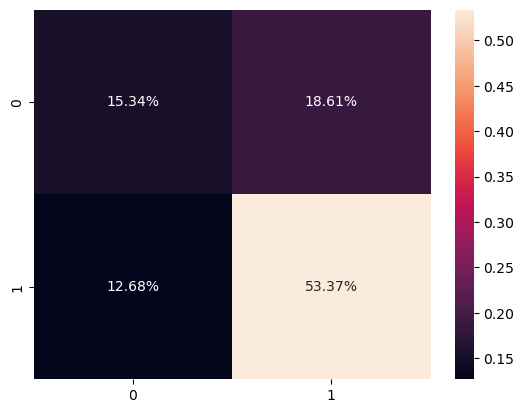

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> 
Test Accuracy :  67.48%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.53      0.33      0.41       166
           1       0.71      0.85      0.78       323

    accuracy                           0.67       489
   macro avg       0.62      0.59      0.59       489
weighted avg       0.65      0.67      0.65       489

             Confusion_matrix 


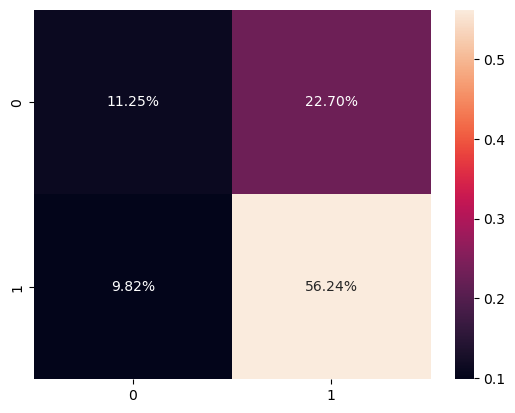

###################- End -###################
#############################################
######-Model => <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> 
Test Accuracy :  52.97%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.19      0.12      0.15       166
           1       0.62      0.74      0.68       323

    accuracy                           0.53       489
   macro avg       0.41      0.43      0.41       489
weighted avg       0.48      0.53      0.50       489

             Confusion_matrix 


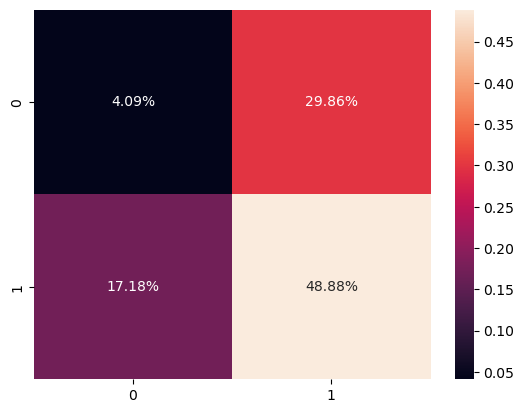

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.ExtraTreesClassifier'> 
Test Accuracy :  67.69%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.53      0.46      0.49       166
           1       0.74      0.79      0.76       323

    accuracy                           0.68       489
   macro avg       0.63      0.63      0.63       489
weighted avg       0.67      0.68      0.67       489

             Confusion_matrix 


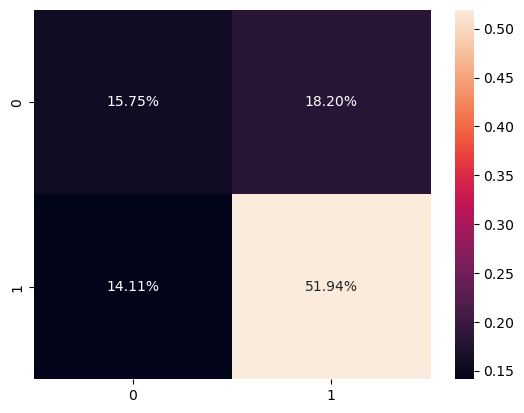

###################- End -###################


In [179]:
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


X = data.drop(['domain','score','label','targetBrand'],axis=1)
y = data['label']
# X = walmartData.drop(['domain','score','label','targetBrand'], axis=1)
# y = walmartData['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
models = [DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,SGDClassifier,ExtraTreesClassifier]
accuracy_test=[]
    

for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    
    
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
    plt.show()
    print('\033[31m###################- End -###################\033[0m')

In [180]:
output = pd.DataFrame({"Model":['Decision Tree Classifier','Random Forest Classifier','AdaBoost Classifier','SGD Classifier','Extra Trees Classifier'],
                      "Accuracy":accuracy_test})

output

,Model,Accuracy
0,Decision Tree Classifier,0.648262
1,Random Forest Classifier,0.687117
2,AdaBoost Classifier,0.674847
3,SGD Classifier,0.529652
4,Extra Trees Classifier,0.676892


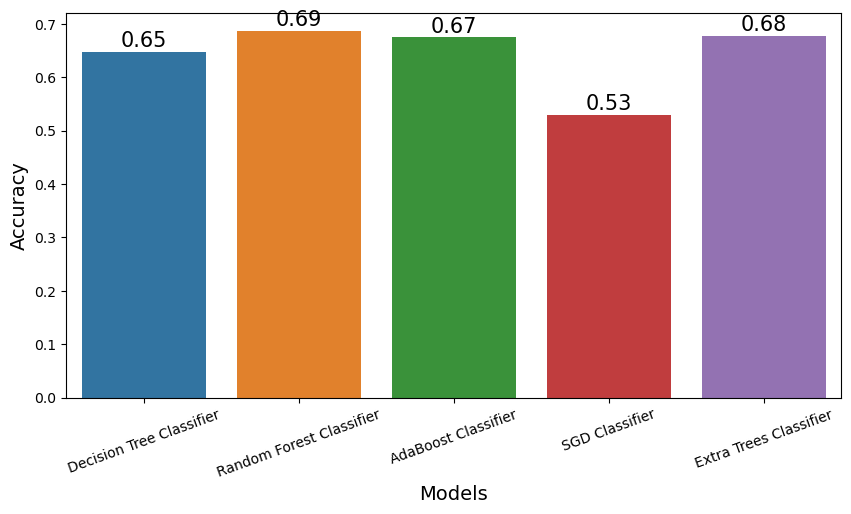

In [181]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()

In [182]:
# all 0.6472392638036809 => 수정 후 60% :: 0.65 0.7 0.68 0.34 0.68
# google 0.868
# facebook 0.64
# microsoft 0.575
# apple 0.795
# wellsfargo 0.668
# roblox 0.858
# homedepot 0.657
# amazon 0.635
# linkedin 0.826
# walmart 0.836

output.Accuracy.mean()

0.6433537832310838

In [183]:
# algorithm !!!!!!!!!!!!!
# algorithm !!!!!!!!!!!!!
# algorithm !!!!!!!!!!!!!
# algorithm !!!!!!!!!!!!!
# algorithm !!!!!!!!!!!!!

In [184]:
X = data.drop(['score'], axis=1)
Y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_test = X_test.drop(['label'], axis=1)

In [174]:
X_train.head(10)

,domain,label,targetBrand,length,digit,hyphen,dot,subDomain,diffLength,checkDigit,checkAddAlpha,checkVowelset,ExtractWord,checkWord,tldLength,ExtractTld,tailOrHead,checkCharset,checkBit,checkRepetition
233,signingoogle.com,1,google.com,16,0,0,1,0,6,0,1,0,115105103110105110,1,3,99111109,0,0,0,0.0
433,faxcebook.com,1,facebook.com,13,0,0,1,0,1,0,1,0,0,0,3,99111109,0,0,0,0.0
1430,amazonverify.com,0,amazon.com,16,0,0,1,0,6,0,1,0,118101114105102121,1,3,99111109,0,0,0,0.0
307,facerook.com,1,facebook.com,12,0,0,1,0,0,0,0,0,0,0,3,99111109,0,0,1,0.0
2197,linkedin.online,1,linkedin.com,15,0,0,1,0,3,0,1,0,0,0,6,111110108105110101,0,1,0,0.0
2358,homwedepot.com,0,homedepot.com,14,0,0,1,0,1,0,1,0,0,0,3,99111109,0,0,0,0.0
383,fac-ebook.com,1,facebook.com,13,0,1,1,0,1,0,1,0,0,0,3,99111109,0,0,0,0.0
1822,robloxu.com,0,roblox.com,11,0,0,1,0,1,0,1,0,0,0,3,99111109,1,0,0,0.0
1382,imazon.com,1,amazon.com,10,0,0,1,0,0,0,0,1,0,0,3,99111109,0,0,1,0.0
2260,homeeepot.com,0,homedepot.com,13,0,0,1,0,0,0,0,0,0,0,3,99111109,0,0,1,0.0


In [78]:
X_test.head(10)

,domain,targetBrand,length,digit,hyphen,dot,subDomain,diffLength,checkDigit,checkAddAlpha,ExtractWord,checkWord,ExtractTld,checkPositionChange,checkBit,checkVowelset
1487,amaazon.com,amazon.com,11,0,0,1,0,1,0,1,0,0,99111109,0,0,0
1808,robloxc.com,roblox.com,11,0,0,1,0,1,0,1,0,0,99111109,0,0,0
1347,amazonn.com,amazon.com,11,0,0,1,0,1,0,1,0,0,99111109,0,0,0
521,microsoft3.com,microsoft.com,14,1,0,1,0,1,1,0,0,0,99111109,0,0,0
1879,verificationroblox.com,roblox.com,22,0,0,1,0,12,0,1,1181011141051021059997116105111110,1,99111109,0,0,0
2361,hmedepot.com,homedepot.com,12,0,0,1,0,-1,0,0,0,0,99111109,0,0,0
2438,homedeput.com,homedepot.com,13,0,0,1,0,0,0,0,0,0,99111109,0,1,1
1511,amazo9n.com,amazon.com,11,1,0,1,0,1,1,0,0,0,99111109,0,0,0
1988,linkedin1.com,linkedin.com,13,1,0,1,0,1,1,0,0,0,99111109,0,0,0
239,updategoogle.com,google.com,16,0,0,1,0,6,0,1,11711210097116101,1,99111109,0,0,0


In [185]:
def SquattingScore(sample):
    target = sample['targetBrand']
    featureList = X_test.columns[2:]
    group = X_train[X_train.targetBrand == target] # target Brand가 같은 sample 수집 
    

    squatting_score = []
    Bs = 0
    Ps = 0
    
    for i in featureList:
        subGroup = group[group[i] == sample[i]] # ex ) length == 11 인 group 내에 있는 sample들.
        labelCount = list(subGroup.label.value_counts().sort_index()) # 0 n개 1 x개
        #print(labelCount)
        
        if (len(labelCount) == 1) & (len(group.label.values == 0) != 0): # label이 하나 밖에 없는 데 그게 benign일 때
            BenignSquatting = 1
            PhishingSquatting = 0
        elif (len(labelCount) == 1) & (len(group.label.values == 1) != 0):
            BenignSquatting = 0
            PhishingSquatting = 1
        elif (len(labelCount) == 2):
            BenignSquatting = labelCount[0] / len(subGroup)
            PhishingSquatting = labelCount[1] / len(subGroup)
        else:
            BenignSquatting = 0
            PhishingSquatting = 0
        
        squatting_score.append([BenignSquatting, PhishingSquatting])
    
    for i in range(len(squatting_score)):
        Bs = Bs + squatting_score[i][0]
        Ps = Ps + squatting_score[i][1]
        
    Bs = round(Bs, 4)
    Ps = round(Ps, 4)
    
    return [Bs, Ps]

In [186]:
squattingDomain_result = []

TP = 0 # 실제대로 분류 T -> T
TN = 0 # 실제대로 분류 F -> F
FN = 0 # 반대로 분류 benign -> phishing
FP = 0 # 반대로 분류 phishing -> benign


for i in range(len(X_test)):
    result = SquattingScore(X_test.iloc[i])
    print(result)
    
    if result[0] > result[1]: # benign으로 예측 
        squattingDomain_result.append(0)
    elif result[0] < result[1]: # phishing으로 예측 
        squattingDomain_result.append(1)
    

for i in range(len(squattingDomain_result)):
    if (y_test.iloc[i] == squattingDomain_result[i]) & (y_test.iloc[i] == 0): # 예측이 맞았고 그게 benign이면 
        TP = TP + 1
    elif (y_test.iloc[i] == squattingDomain_result[i]) & (y_test.iloc[i] == 1):
        TN = TN + 1
    elif (y_test.iloc[i] != squattingDomain_result[i]) & (y_test.iloc[i] == 0): #예측이 틀렸고 원래 label = benign 0->1
        FN = FN + 1
    elif (y_test.iloc[i] != squattingDomain_result[i]) & (y_test.iloc[i] == 1): 
        FP = FP + 1

        
accuracy = (TP + TN) / len(X_test)
miss = (FN + FP) / len(X_test)

precision = TP / (TP+FP)
recall = TP / (TP+FN)
f1_score = 2 * (((precision * recall) / (precision + recall)))

[12.3586, 4.6414]
[1.841, 15.159]
[12.6868, 4.3132]
[7.1928, 9.8072]
[1.7636, 12.2364]
[13.4852, 3.5148]
[14.0391, 2.9609]
[11.7197, 5.2803]
[3.5646, 13.4354]
[2.0765, 13.9235]
[6.987, 10.013]
[3.2205, 13.7795]
[11.7335, 5.2665]
[7.0954, 9.9046]
[10.5065, 5.4935]
[14.3443, 2.6557]
[6.972, 10.028]
[7.1819, 9.8181]
[6.8485, 10.1515]
[12.5065, 4.4935]
[6.8191, 10.1809]
[13.9985, 3.0015]
[4.5037, 12.4963]
[3.3277, 12.6723]
[12.0344, 4.9656]
[11.1736, 4.8264]
[5.2544, 10.7456]
[7.896, 8.104]
[13.9985, 3.0015]
[1.9142, 15.0858]
[3.1087, 13.8913]
[12.0479, 4.9521]
[5.5125, 11.4875]
[13.6324, 3.3676]
[3.0258, 12.9742]
[1.897, 15.103]
[2.795, 14.205]
[6.156, 9.844]
[3.2955, 12.7045]
[6.987, 10.013]
[5.6912, 11.3088]
[5.1368, 10.8632]
[2.0558, 14.9442]
[2.2553, 14.7447]
[12.3626, 4.6374]
[8.2874, 7.7126]
[1.9142, 15.0858]
[7.522, 9.478]
[5.705, 11.295]
[5.9487, 10.0513]
[11.7244, 4.2756]
[6.8485, 10.1515]
[3.4922, 13.5078]
[6.797, 10.203]
[5.9622, 9.0378]
[6.8485, 10.1515]
[6.8485, 10.1515]
[7.4

[6.8485, 10.1515]
[3.0765, 13.9235]
[6.1654, 10.8346]
[3.0258, 12.9742]
[6.987, 10.013]
[11.5065, 5.4935]
[1.9247, 15.0753]
[14.2253, 2.7747]
[10.7787, 5.2213]
[6.4572, 9.5428]
[2.3816, 14.6184]
[6.797, 10.203]
[11.7244, 4.2756]
[10.5065, 5.4935]
[3.6733, 11.3267]


In [187]:
print(TP, TN, FN, FP)
print(accuracy, miss)
print(precision, recall, f1_score)

74 287 103 25
0.7382413087934561 0.261758691206544
0.7474747474747475 0.4180790960451977 0.536231884057971


In [325]:
#benign -> phishing으로 판단한 경우가 104개 (FN)

In [188]:
accuracy_test.append(accuracy)



In [189]:
output = pd.DataFrame({"Model":['Decision Tree Classifier','Random Forest Classifier','AdaBoost Classifier','SGD Classifier','Extra Trees Classifier','Mymodel'],
                      "Accuracy":accuracy_test})

output

,Model,Accuracy
0,Decision Tree Classifier,0.648262
1,Random Forest Classifier,0.687117
2,AdaBoost Classifier,0.674847
3,SGD Classifier,0.529652
4,Extra Trees Classifier,0.676892
5,Mymodel,0.738241


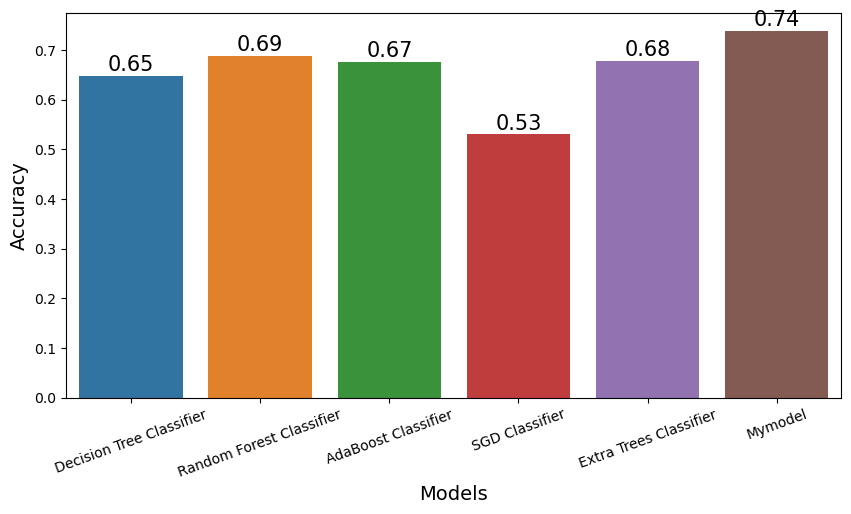

In [190]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()

In [191]:
# 여기서부터 이어서 
# 여기서부터 이어서 
# 여기서부터 이어서 
# 여기서부터 이어서 

In [91]:
# FN sample만 따로 모아보기 

FN_index = []
for i in range(len(squattingDomain_result)):
    if (squattingDomain_result[i] != y_test.iloc[i]) & (y_test.iloc[i] == 0): # 예측 label VS 실제 label
        FN_index.append(i)

In [92]:
print(FN_index)

[16, 17, 20, 27, 32, 37, 41, 42, 47, 48, 57, 61, 63, 69, 71, 74, 80, 91, 92, 107, 112, 114, 117, 118, 121, 124, 130, 136, 141, 142, 143, 152, 157, 158, 172, 173, 179, 180, 185, 192, 194, 203, 208, 212, 220, 222, 235, 236, 237, 240, 249, 250, 264, 268, 270, 272, 276, 277, 280, 281, 285, 291, 296, 304, 316, 320, 329, 332, 334, 336, 337, 341, 344, 351, 352, 359, 363, 367, 370, 371, 374, 376, 378, 387, 394, 397, 403, 421, 426, 432, 433, 434, 436, 437, 445, 450, 452, 453, 459, 473, 478, 483, 484, 488]


In [100]:
FN_sample = [] # 실제로는 benign인데 phishing으로 분류한 경우의 sample들만 수집

for i in FN_index:
        FN_sample.append(X_test.iloc[i])

In [102]:
FN_sample[0]

domain                 wellsfa4go.com
targetBrand            wellsfargo.com
length                             14
digit                               1
hyphen                              0
dot                                 1
subDomain                           0
diffLength                          0
checkDigit                          1
checkAddAlpha                       0
ExtractWord                         0
checkWord                           0
ExtractTld                   99111109
checkPositionChange                 0
checkBit                            1
checkVowelset                       0
Name: 1263, dtype: object

In [105]:
FN_sample = pd.DataFrame(FN_sample, columns=['domain','targetBrand','length','digit','hyphen','dot','subDomain','diffLength',
                                             'checkDigit','checkAddAlpha','ExtractWord','checkWord','ExtractTld','checkPositionChange',
                                             'checkBit','checkVowelset'])

In [106]:
FN_sample.head()

,domain,targetBrand,length,digit,hyphen,dot,subDomain,diffLength,checkDigit,checkAddAlpha,ExtractWord,checkWord,ExtractTld,checkPositionChange,checkBit,checkVowelset
1263,wellsfa4go.com,wellsfargo.com,14,1,0,1,0,0,1,0,NaN,0,99111109,0,1,0
443,facebok.com,facebook.com,11,0,0,1,0,-1,0,0,NaN,0,99111109,0,0,0
450,facebbook.com,facebook.com,13,0,0,1,0,1,0,1,NaN,0,99111109,0,0,0
808,microsoft.info,microsoft.com,14,0,0,1,0,1,0,1,NaN,0,105110102111,0,0,0
1070,wellsfargoz.com,wellsfargo.com,15,0,0,1,0,1,0,1,NaN,0,99111109,0,0,0


In [111]:
FN_sample.describe()

,length,digit,hyphen,dot,subDomain,diffLength,checkDigit,checkAddAlpha,ExtractWord,checkWord,checkPositionChange,checkBit,checkVowelset
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,0.0,104.000000,104.000000,104.000000,104.000000
mean,13.115385,0.105769,0.096154,1.048077,0.048077,1.105769,0.105769,0.480769,NaN,0.134615,0.019231,0.317308,0.038462
std,2.770537,0.309031,0.296230,0.214965,0.214965,2.057042,0.309031,0.502050,NaN,0.342965,0.138000,0.467682,0.193239
min,8.000000,0.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
25%,11.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
50%,13.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
75%,14.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,NaN,0.000000,0.000000,1.000000,0.000000
max,21.000000,1.000000,1.000000,2.000000,1.000000,8.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000


In [112]:
FN_sample.domain

1263          wellsfa4go.com
443              facebok.com
450            facebbook.com
808           microsoft.info
1070         wellsfargoz.com
                ...         
1018              app.le.com
785            microyoft.com
647     secure-microsoft.com
128              ggoogle.com
1017              a.pple.com
Name: domain, Length: 104, dtype: object